In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
import cvxpy as cp

# Шаг 1: Загружаем данные

In [149]:
tickers = ['AAPL', 'MSFT', 'AMZN',] #'TSLA']
data = yf.download(tickers, start="1995-01-01", end="2025-07-02", interval='1mo')

C:\Users\pluso\AppData\Local\Temp\ipykernel_18184\682121654.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="1995-01-01", end="2025-07-02", interval='1mo')
[*********************100%***********************]  3 of 3 completed


In [150]:
data.head(3)

Price          Close                     High                      Low       \
Ticker          AAPL AMZN      MSFT      AAPL AMZN      MSFT      AAPL AMZN   
Date                                                                          
1995-01-01  0.299935  NaN  2.274826  0.357043  NaN  2.499913  0.281364  NaN   
1995-02-01  0.293436  NaN  2.413709  0.330579  NaN  2.423287  0.282292  NaN   
1995-03-01  0.262583  NaN  2.725001  0.303553  NaN  2.839940  0.252340  NaN   

Price                     Open                     Volume                   
Ticker          MSFT      AAPL AMZN      MSFT        AAPL AMZN        MSFT  
Date                                                                        
1995-01-01  2.231723  0.288792  NaN  2.356240  8162100800  NaN  1111609600  
1995-02-01  2.236512  0.302721  NaN  2.274825  5299347200  NaN   998657600  
1995-03-01  2.404131  0.296104  NaN  2.418498  6997144000  NaN  1415724800

In [151]:
data.tail(3)

Price            Close                                High              \
Ticker            AAPL        AMZN        MSFT        AAPL        AMZN   
Date                                                                     
2025-05-01  200.586960  205.009995  459.516388  214.278996  214.839996   
2025-06-01  205.169998  219.389999  497.410004  207.389999  223.820007   
2025-07-01  211.160004  225.020004  503.320007  216.229996  226.679993   

Price                          Low                                Open  \
Ticker            MSFT        AAPL        AMZN        MSFT        AAPL   
Date                                                                     
2025-05-01  461.672433  192.996907  183.850006  424.121376  208.806177   
2025-06-01  500.760010  195.070007  202.679993  456.890015  200.279999   
2025-07-01  506.779999  206.139999  217.929993  488.700012  206.669998   

Price                                   Volume                          
Ticker            AMZN        MSFT        AAPL         AMZN       MSFT  
Date                                                                    
2025-05-01  190.630005  430.319988  1195728200  937262700.0  476942400  
2025-06-01  204.979996  457.140015  1100409300  870687900.0  401255100  
2025-07-01  219.500000  496.470001   407676700  301095600.0  127684600

In [152]:
def resample_open_to_close_returns(df: pd.DataFrame, freq='YE') -> pd.DataFrame:
    """
    Считает доходности между Open начала периода и Close конца периода.
    Ожидается DataFrame с колонками MultiIndex: [('AAPL', 'Open'), ('AAPL', 'Close'), ...]
    """
    # Убедимся, что формат — MultiIndex: тикеры × ['Open', 'Close']
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    tickers = df.columns.get_level_values(1).unique()
    result = pd.DataFrame(index=[], columns=tickers)

    for ticker in tickers:
        open_series = df['Open'][ticker].resample(freq).first()
        close_series = df['Close'][ticker].resample(freq).last()
        ret = (close_series / open_series - 1).dropna()
        result[ticker] = ret

    return result

In [153]:
# Доходности Open → Close на год
freq = 'YE' # 'QE'
returns = resample_open_to_close_returns(data, freq='YE')

In [154]:
returns

Ticker,AAPL,AMZN,MSFT
Date,,,
1995-12-31,-0.170704,NaN,0.426829
1996-12-31,-0.352712,NaN,0.880511
1997-12-31,-0.378695,1.059832,0.554887
1998-12-31,2.004577,9.708332,1.139826
1999-12-31,1.440654,0.393859,0.672523
2000-12-31,-0.716329,-0.809049,-0.630458
2001-12-31,0.472267,-0.315731,0.501417
2002-12-31,-0.350113,0.728271,-0.224306
2003-12-31,0.488158,1.742053,0.055910


# 2. Вычисление статистик

In [155]:
periods_back = 7 #len(returns)
count_2025 = -1 #len(returns)
returns.iloc[-periods_back:count_2025]

Ticker,AAPL,AMZN,MSFT
Date,,,
2019-12-31,0.924347,0.261152,0.607552
2020-12-31,0.807128,0.737029,0.415646
2021-12-31,0.338112,0.019676,0.524015
2022-12-31,-0.265118,-0.498657,-0.278166
2023-12-31,0.486077,0.777908,0.560697
2024-12-31,0.344626,0.447737,0.135858


In [156]:
mean_returns = returns.iloc[-periods_back:count_2025].mean()
returns_std = returns.iloc[-periods_back:count_2025].std()
cov_matrix = returns.iloc[-periods_back:count_2025].cov()

In [157]:
mean_returns

Ticker
AAPL    0.439195
AMZN    0.290807
MSFT    0.327600
dtype: float64

In [158]:
returns_std

Ticker
AAPL    0.421465
AMZN    0.481384
MSFT    0.341396
dtype: float64

In [159]:
cov_matrix

Ticker,AAPL,AMZN,MSFT
Ticker,,,
AAPL,0.177633,0.148245,0.120814
AMZN,0.148245,0.231731,0.107883
MSFT,0.120814,0.107883,0.116551


In [160]:
returns.corr()

Ticker,AAPL,AMZN,MSFT
Ticker,,,
AAPL,1.000000,0.489312,0.457634
AMZN,0.489312,1.000000,0.585647
MSFT,0.457634,0.585647,1.000000


# 3. Симуляция случайных портфелей

In [161]:
n_portfolios = 50000
results = np.zeros((3, n_portfolios))

In [162]:
%%time
for i in range(n_portfolios):
    weights = np.random.rand(len(tickers))
    weights /= np.sum(weights)
    
    port_return = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = port_return / port_std
    
    results[0, i] = port_return
    results[1, i] = port_std
    results[2, i] = sharpe

CPU times: total: 2.94 s
Wall time: 2.94 s


# 4. Визуализация

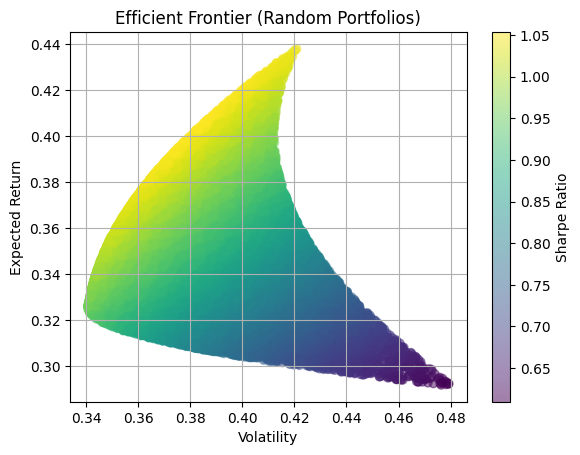

In [163]:
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', marker='o', alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier (Random Portfolios)')
plt.grid(True)
plt.show()

# 5. Оптимальный портфель при заданной доходности (библиотека cvxpy)

In [164]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, std

In [165]:
def optimizer_function(cov_matrix, ret_target):
    n = len(cov_matrix)
    w = cp.Variable(n)

    objective = cp.Minimize(cp.quad_form(w, cov_matrix.values))
    constraints = [cp.sum(w) == 1,
                   mean_returns.values @ w >= ret_target,
                   w >= 0]
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w

In [166]:
w = optimizer_function(cov_matrix, 0.40)

# === 8. Вывод весов оптимального портфеля ===
print("Optimal weights (min volatility):")
for ticker, weight in zip(tickers, w.value):
    print(f"{ticker}: {weight:.2%}")

Optimal weights (min volatility):
AAPL: 64.88%
MSFT: 0.00%
AMZN: 35.12%


In [167]:
opt_return, opt_std = portfolio_performance(w.value, mean_returns, cov_matrix)

In [168]:
opt_return, opt_std

(np.float64(0.4), np.float64(0.37974099244778603))

In [169]:
returns_std

Ticker
AAPL    0.421465
AMZN    0.481384
MSFT    0.341396
dtype: float64

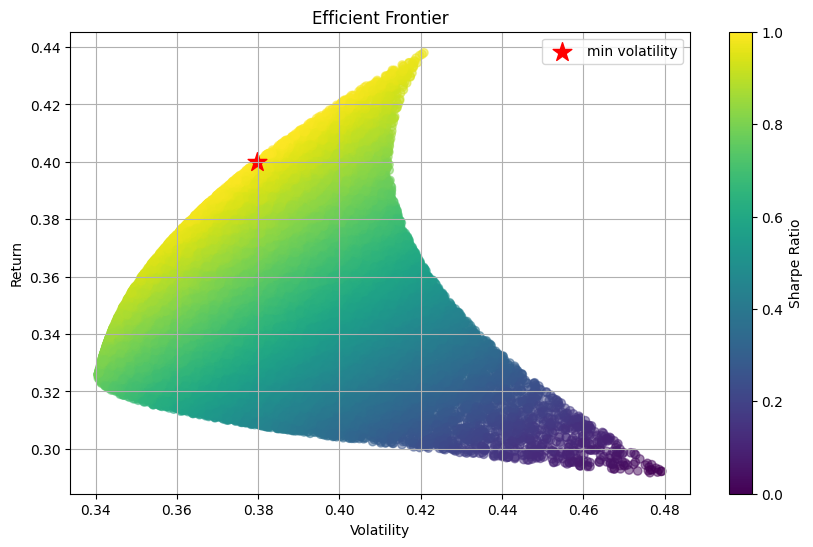

In [170]:
# === 6. Визуализация ===
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.5)
plt.scatter(opt_std, opt_return, color='red', marker='*', s=200, label='min volatility')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()